In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import plotly.graph_objs as go
from fbprophet.plot import plot_plotly
import plotly.offline as pyo
import holidays
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
pyo.init_notebook_mode()
pd.plotting.register_matplotlib_converters()

In [3]:
US_holidays = holidays.UnitedStates()

# FORECASTING BIKE SHARING RENTALS USING PROPHET

This project was inspired by the Kaggle competition: [Bike Share Demand : Forecast the city bikeshare demand](https://www.kaggle.com/c/bike-share-demand)

Competition description :
>Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

>The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

Original history trip data can be fout at [capitalbikeshare.com](https://www.capitalbikeshare.com/system-data)

Data includes :

* date : format YYYY-MM-DD

* Member : the daily number of rentals made by registered members of the bikeservice (Annual Member, 30-Day Member or Day Key Member)

* Casual :  the daily number of rentals made by unregistered members of the bikeservice (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)


### data loading

In [4]:
df = pd.read_csv('capitalbikeshare_dataset_2010_2018.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

Casual  Member
date                      
2010-09-20      34     178
2010-09-21     109     215
2010-09-22     117     260
2010-09-23     124     249
2010-09-24     156     206

### feature extraction

In [5]:
df['count'] = df.sum(axis=1)
df['is_holiday'] = df.index.map(lambda x: x in US_holidays )
df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['year'] = df.index.map(lambda x: x.year)
df['month'] = df.index.map(lambda x: x.month)
df['dayofmonth'] = df.index.map(lambda x: x.day)

## I. EXPLORATORY DATA ANALYSIS

### I.1. TIME SERIES

In [6]:
fig = go.Figure(
    [
        go.Scatter(x=df.index, y=df['Casual'], name='casual rides'),
        go.Scatter(x=df.index, y=df['Member'], name='registered rides'),
        go.Scatter(x=df.loc[df.is_holiday].index, y=df.loc[df.is_holiday]['Member'], mode='markers', name='holiday'),
    
    ])
fig.update_xaxes(
    rangeslider_visible=True
)
fig.show()

### Observations
From the graph above, we can already gather valuable insight for our modeling decision.
At first glance, the timeseries seems to be very similar:
- trended : clear upward trend 
- seasonality : strong recurring pattern on a yearly basis 
- holiday sensible: peaks occuring on some holidays

### I.2. MULTIPLOTS

In [7]:
def plot_multiplot(y):
    figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    figure.set_size_inches(12, 8)
    sns.pointplot(data=df, x='dayofmonth', y=y, hue='year', ax=ax1)
    sns.pointplot(data=df, x='month', y=y, hue='year', ax=ax2)
    sns.boxplot(data=df, x='year', y=y, ax=ax3)
    sns.pointplot(data=df, x='dayofweek', y=y, hue='year', ax=ax4)    

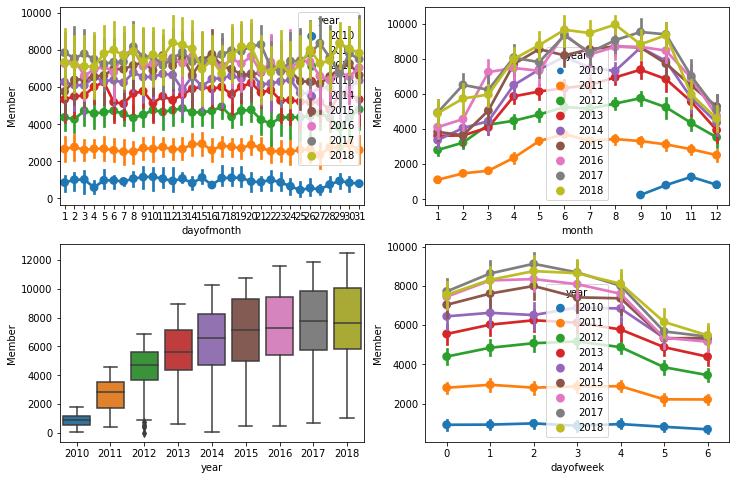

In [8]:
multiplot_member = plot_multiplot('Member')

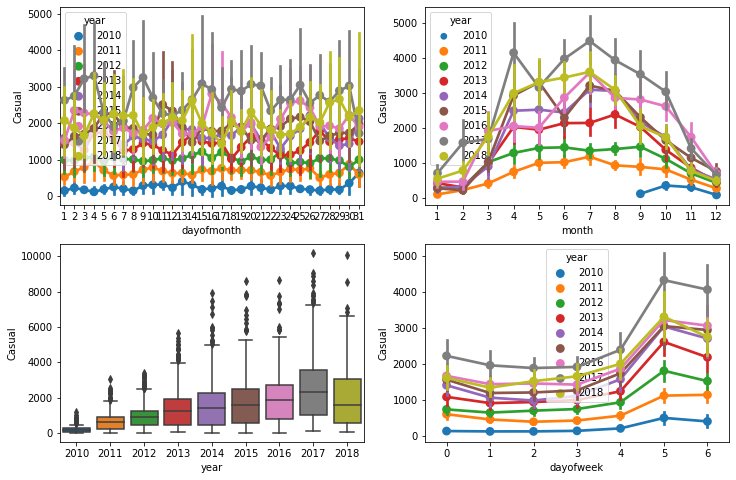

In [9]:
multiplot_casual = plot_multiplot('Casual')

### Observations :

In both cases, those plots highlight a strong seasonality on a weekly and yearly level.

Yearly seasonality can easely be explained as their is biking practicabily and enjoyement is highly correlated with meteorological conditions. Thus, this seasonal pattern is generalized to both casual and registered bikers.

Meanwhile on a weekly basis, we  witness antagonistic behaviors.
For members, peak activity happens on the working days while for casuals it happens on the weekends.
This difference leads us to think that registered bikers must used bike sharing sevice as a commuting mean while casual riders use it for leasure purposes. 

It confort the decision to make two distincts models to catch to reflect on those differences.

Holidays impact must be considered.

Finaly, notice on both boxplots how the spread tends to grow as years pass.
If timeseries where to be additive, spread would be constant.
This is a good insight that both timeseries are likely to follow a multiplicative model.
 
### Model:
for all day t, 
\begin{equation}
Y_t = Y_t^{member}+ Y_t^{casual} \\
Y_t^{member} = T_t^{member} * S_t^{weekly, member} * S_t^{yearly, member} * \epsilon_t^{member} * H_t^{member} \\
Y_t^{casual} = T_t^{casual} * S_t^{weekly, casual} * S_t^{yearly, casual} * \epsilon_t^{casual}  * H_t^{casual}\\
\text{with:} \\
Y_t : \text{the number of location on date t} \\
Y_t^{member} : \text{the number of location made by members on date t} \\
Y_t^{casual} : \text{the number of location made by casual users on date t} \\
T_t^{casual} : \text{trend on date t} \\
S_t^{weekly}:\text{weekly seasonal component on date t} \\
S_t^{yearly}:\text{yearly seasonal component on date t} \\
\epsilon_t:\text{residuals on date t} \\
\ H_t:\text{holiday component on date t} \\
\end{equation}

## II. Implementing Prophet

### train test split

In [10]:
# Train set : 2010/2016
df_train = df.loc[:'2016'].copy(deep=True)
# Test set : 2016/2018
df_test = df.loc['2016':].copy(deep=True)

### reformating
Prophet requires a specific columns naming convention:
* ds: date column
* y: predictor column 

In [11]:
X_train_casual = df_train[['Casual']].reset_index().copy(deep=True)
X_train_casual.columns = ['ds','y']

X_train_registered = df_train[['Member']].reset_index().copy(deep=True)
X_train_registered.columns = ['ds','y']

### II.1. Data Transformation

Like most regression models, Prophet assumes that noise in our dataset in normaly distributed.
We have strong reasons to believe that the assumption is not verified espacialy when our hypothesis is that 
bike sharing rental follows a multiplicative model. 
If the skew is reduced, our model will fit better. 
In order to tend to normal noise model, we will project our data in a transformed space using Cox-Box transformation.

Box Cox transformation depends on a parameter lambda. 
Basicaly, running a Box Cox transformation is considering all possible lambda values 
to find the lambda that maximize the approximation of normal distribution curve.
A lambda of 0 is equivalent to a log transformation, 0.5 a square root transformation.

In [12]:
X_train_registered['y'], lambda_registered = boxcox(X_train_registered['y'])
print('lambda registered : {0:.2f}'.format(lambda_registered))
X_train_casual['y'], lambda_casual = boxcox(X_train_casual['y'])
print('lambda casual : {0:.2f}'.format(lambda_casual))

lambda registered : 0.74
lambda casual : 0.26


### II.2. Defining our models

Based on our observations made previously, we instanciates our models.
Prophet comes with pre-parametrizied seasonalities but we will override them in order to tweek them.
Fourier orders correspond to the number of sinusoïd signals use to fit the seasonality.
In short, a higher order means we have higher frequency terms and so will be able to fit more quickly-changing and complex seasonality patterns. Often it comes at the expense of overfitting but because we will be using 6 years of data, that's enough to reduce variability.

In [13]:
def init_model(**params):
    model = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        # holidays=holidays,
        yearly_seasonality=False,
        daily_seasonality=False,
        weekly_seasonality=False,
    )
    model.add_seasonality(
        name='weekly',
        period=7,
        fourier_order=params['weekly_fourier_order'],
        prior_scale=params['weekly_prior_scale']
    )
    model.add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=params['yearly_fourier_order'],
        prior_scale=params['yearly_prior_scale'],
    )
    #adding US holidays as extra regressors of our model
    model.add_country_holidays(country_name='US')
    return model

In [14]:
casual_params = {
    'weekly_fourier_order':20,
    'weekly_prior_scale':0.05,
    'yearly_fourier_order':25,
    'yearly_prior_scale':0.1
}
model_casual = init_model(**casual_params)
model_casual.fit(X_train_casual)

In [15]:
registered_params = {
    'weekly_fourier_order':20,
    'weekly_prior_scale':0.05,
    'yearly_fourier_order':27,
    'yearly_prior_scale':0.1
}
model_registered = init_model(**registered_params)
model_registered.fit(X_train_registered)

### II.3. Predicting

In [16]:
# generating dataframe with a columnn ds containing dates for which a prediction is to be made
future = model_casual.make_future_dataframe(periods=365*2)
future.tail(3)

ds
3018 2018-12-29
3019 2018-12-30
3020 2018-12-31

In [17]:
forecast_casual = model_casual.predict(future)

In [18]:
forecast_registered = model_registered.predict(future)

## II. FORECAST AND DECOMPOSITION

### II.1. FORECAST

NB : Keep in mind that the data displayed in graphs below has been transform.
To get actual prediction values will have to inverse transform it back to the original space. (see. inverse transformation )

### a. member

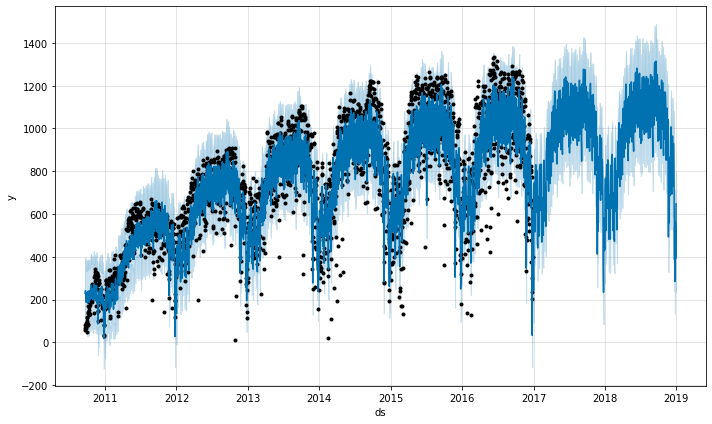

In [19]:
fig_forecast_registered = model_registered.plot(forecast_registered)

### b.casual

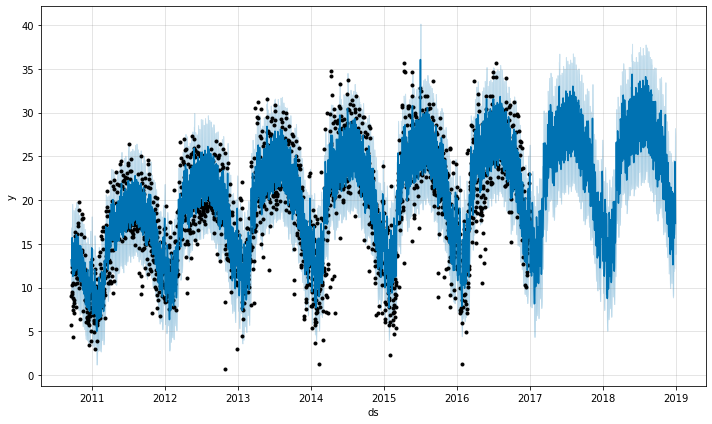

In [20]:
fig_forecast_casual = model_casual.plot(forecast_casual)

### II.2. DECOMPOSITION

### a. member

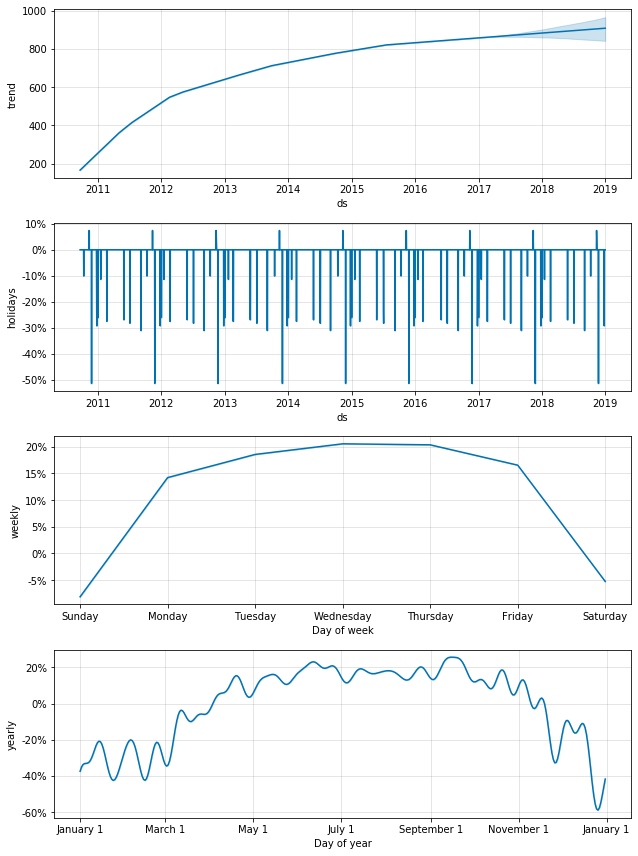

In [21]:
fig_components_registered = model_registered.plot_components(forecast_registered)

### b. casual

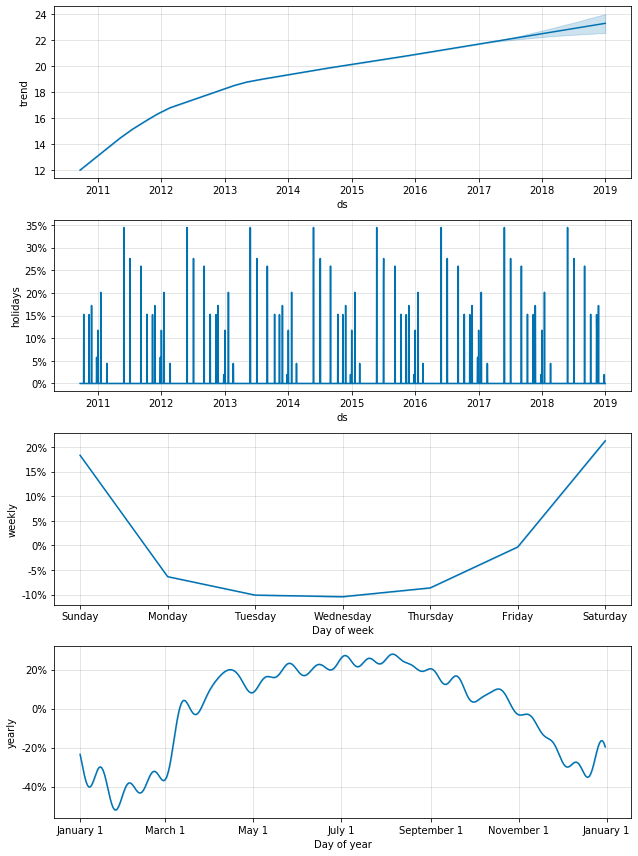

In [22]:
fig_components_casual = model_casual.plot_components(forecast_casual)

## III. MODEL EVALUATION 

In [23]:
### Cox-box inverse transformation 

forecast_casual_tfmd = forecast_casual.set_index('ds').applymap(lambda x: inv_boxcox(x, lambda_casual))
forecast_registered_tfmd = forecast_registered.set_index('ds').applymap(lambda x: inv_boxcox(x, lambda_registered))


In [24]:
# merging forecasts 
forecasts = forecast_casual_tfmd.join(forecast_registered_tfmd, lsuffix='_casual', rsuffix='_registered')
# merging forecasts with actual values 
df_result = df_test.join(forecasts)

### III.1. registered model

In [25]:
rmse_casual = np.sqrt(mean_squared_error(df_result['Member'], df_result['yhat_registered']))
print("RMSE : {}".format(rmse_casual))

RMSE : 1591.7098313251267


In [26]:
fig_registered = go.Figure(
    [
       
        go.Scatter(x=df_result.index, y=df_result['Member'], name="actual rentals"),
        go.Scatter(x=df_result.index, y=df_result['yhat_registered'], name="predicted rentals"),
        go.Scatter(x=df_result.index, y=df_result['trend_registered'], name="trend"),
        go.Scatter(x=df_result.index, y=df_result['trend_registered'] * df_result['yearly_registered'], name="trend x yearly" ),
    ],
    )
fig_registered.update_xaxes(
    rangeslider_visible=True
)
fig_registered.show()

### III.2. casual model

In [27]:
rmse_casual = np.sqrt(mean_squared_error(df_result['Casual'], df_result['yhat_casual']))
print("RMSE : {}".format(rmse_casual))

RMSE : 1143.5450314645238


In [28]:
fig_casual = go.Figure(
    [
       
        go.Scatter(x=df_result.index, y=df_result['Casual'], name="actual rentals"),
        go.Scatter(x=df_result.index, y=df_result['yhat_casual'], name="predicted rentals"),
        go.Scatter(x=df_result.index, y=df_result['trend_casual'], name="trend"),
        go.Scatter(x=df_result.index, y=df_result['trend_casual'] * df_result['yearly_casual'], name="trend x yearly" ),
    ],
    )
fig_casual.update_xaxes(
    rangeslider_visible=True
)
fig_casual.show()